# Smart City traffic patterns

# 1) Importing key modules

In [1]:
# For warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# For processing
import numpy as np
import pandas as pd

In [4]:
# For time series
from datetime import datetime
import time

In [6]:
# For modeling
from sklearn.ensemble import ExtraTreesClassifier
import operator
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

# 2) Loading Dataset

In [7]:
df_train = pd.read_csv("train_aWnotuB.csv")

In [8]:
df_train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [9]:
df_train.shape

(48120, 4)

In [10]:
df_train.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


# 3) Getting to know Data

In [11]:
df_train.dtypes.value_counts()

int64     3
object    1
dtype: int64

**Though it shows three numerical variables. Actually juntion is not exactly a numerical variable. Rather it shows categories of junction and we cannot assume that junc 1 is less than junc2.**

In [12]:
df_train['Junction'].value_counts()

3    14592
2    14592
1    14592
4     4344
Name: Junction, dtype: int64

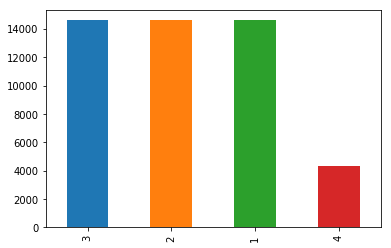

In [13]:
df_train['Junction'].value_counts().plot.bar()

In [14]:
df_test = pd.read_csv("test_BdBKkAj.csv")

In [15]:
df_test.head()

,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041


In [16]:
df_test.shape

(11808, 3)

**As vehicle is missing from test dataset. So vehicle is our target feature i.e y**

## a- Checking missing values

In [17]:
def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
        #missing_vals.append(str(column)+ " column has {} missing or NaN values.".format())
    return missing_vals

In [18]:
missing_values = find_missing_values(df_train, columns=df_train.columns)
missing_values

Number of missing or NaN values for each column:


{'DateTime': 0, 'Junction': 0, 'Vehicles': 0, 'ID': 0}

In [19]:
missing_values = find_missing_values(df_test, columns=df_test.columns)
missing_values

Number of missing or NaN values for each column:


{'DateTime': 0, 'Junction': 0, 'ID': 0}

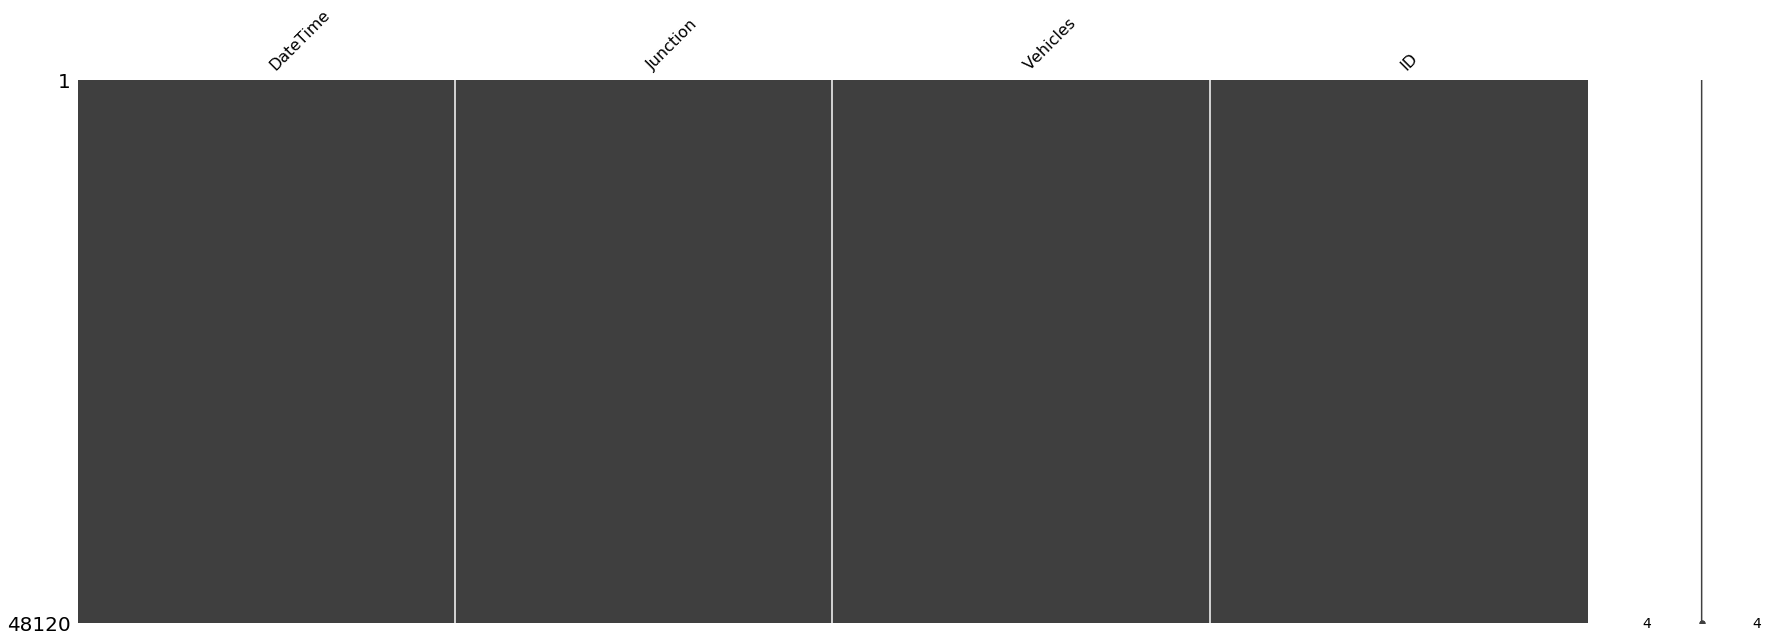

In [20]:
# Plot graphic of missing values
import missingno
missingno.matrix(df_train, figsize = (30,10))

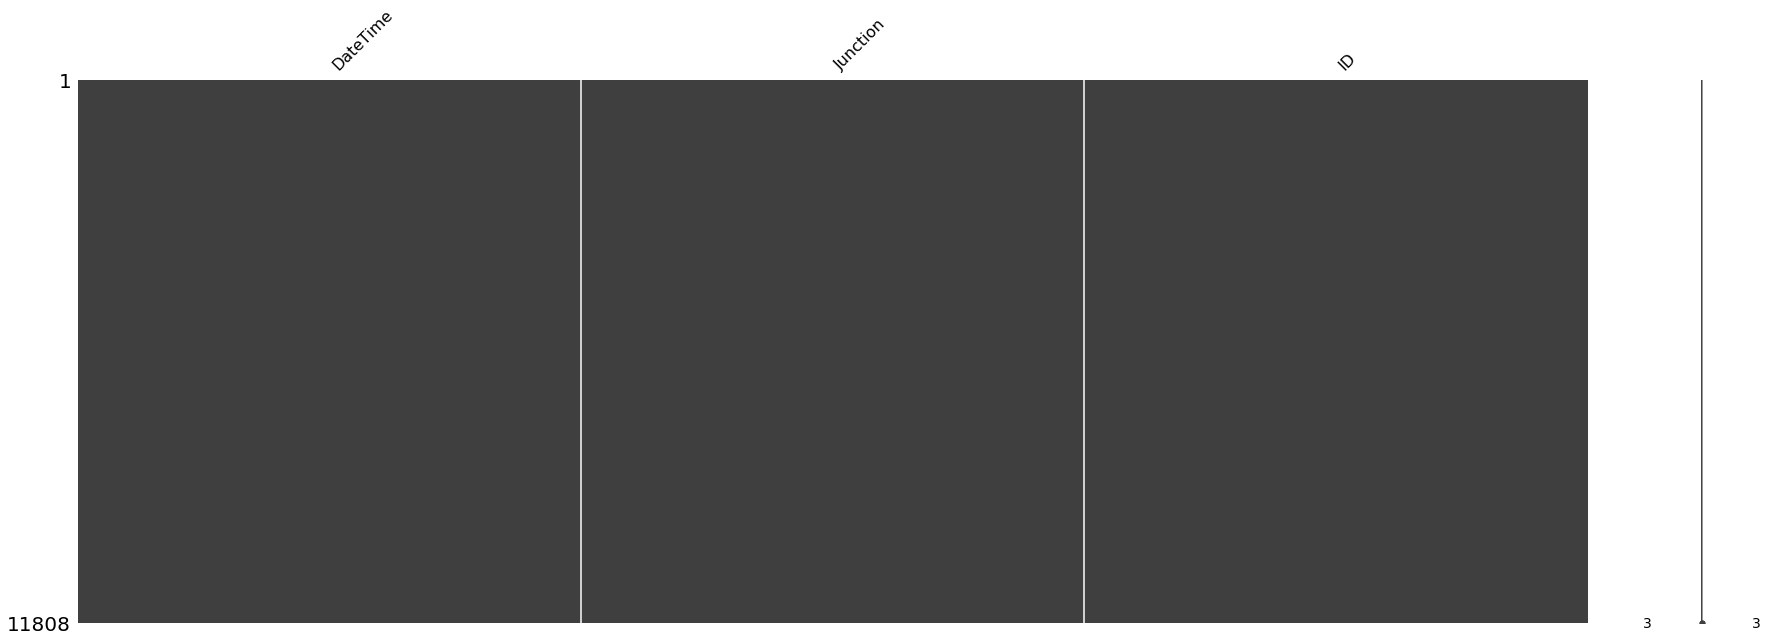

In [21]:
# Plot graphic of missing values
import missingno
missingno.matrix(df_test, figsize = (30,10))

No missing values

## b- Visualizing data features

(array([1.1252e+04, 1.3227e+04, 7.6440e+03, 3.9940e+03, 3.0220e+03,
        2.1920e+03, 1.7470e+03, 1.2590e+03, 9.6000e+02, 7.0800e+02,
        6.5900e+02, 5.3300e+02, 4.1600e+02, 2.1200e+02, 1.3400e+02,
        1.0000e+02, 2.9000e+01, 1.4000e+01, 1.1000e+01, 3.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  1.  ,   8.16,  15.32,  22.48,  29.64,  36.8 ,  43.96,  51.12,
         58.28,  65.44,  72.6 ,  79.76,  86.92,  94.08, 101.24, 108.4 ,
        115.56, 122.72, 129.88, 137.04, 144.2 , 151.36, 158.52, 165.68,
        172.84, 180.  ]),
 <a list of 25 Patch objects>)

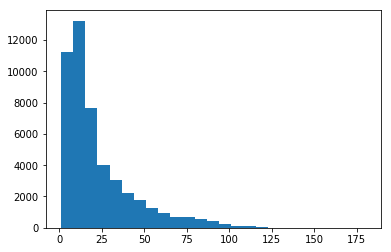

In [22]:
plt.hist('Vehicles' , data=df_train , bins=25)

**Right skewed graph. We might have some outliers**

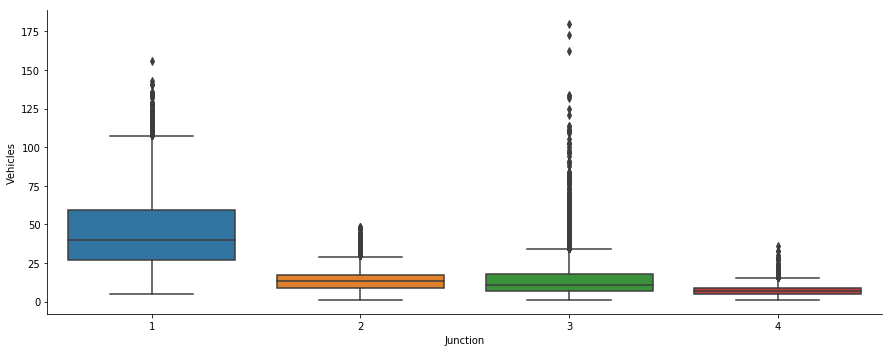

In [23]:
import seaborn as sns
sns.catplot(x='Junction', y='Vehicles' ,data=df_train, kind='box' ,aspect=2.5 )

## c- Checking outliers

In [24]:
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values

In [25]:
tukey_indices, tukey_values = find_outliers_tukey(df_train['Vehicles'])
print(np.sort(tukey_values))

[ 60  60  60 ... 162 173 180]


There are few higher and lower value. We do not have a great list of features so, we cannot make any assumption about these values being too high or too low with respect to other features

## d- Dealing with time and date

In [26]:
# Converting to datetime
from datetime import datetime
import time
df_train['DateTime'] = pd.to_datetime(df_train['DateTime'])
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
DateTime    11808 non-null datetime64[ns]
Junction    11808 non-null int64
ID          11808 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 276.8 KB


In [27]:
df_train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [28]:
df_time=df_train.set_index("DateTime")

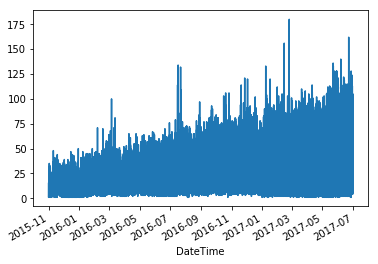

In [29]:
df_time["Vehicles"].plot()

**Vehicle density from November 2015 to August 2017**  

In [30]:
# Creating features from DateTime for train data
df_train['Weekday'] = [datetime.weekday(date) for date in df_train.DateTime]
df_train['Year'] = [date.year for date in df_train.DateTime]
df_train['Month'] = [date.month for date in df_train.DateTime]
df_train['Day'] = [date.day for date in df_train.DateTime]
df_train['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_train.DateTime]
df_train['Week'] = [date.week for date in df_train.DateTime]
df_train['Quarter'] = [date.quarter for date in df_train.DateTime]

In [31]:
# Creating features from DateTime for test data

df_test['Weekday'] = [datetime.weekday(date) for date in df_test.DateTime]
df_test['Year'] = [date.year for date in df_test.DateTime]
df_test['Month'] = [date.month for date in df_test.DateTime]
df_test['Day'] = [date.day for date in df_test.DateTime]
df_test['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_test.DateTime]
df_test['Week'] = [date.week for date in df_test.DateTime]
df_test['Quarter'] = [date.quarter for date in df_test.DateTime]

In [32]:
df_train.head()

,DateTime,Junction,Vehicles,ID,Weekday,Year,Month,Day,Time,Week,Quarter
0,2015-11-01 00:00:00,1,15,20151101001,6,2015,11,1,0,44,4
1,2015-11-01 01:00:00,1,13,20151101011,6,2015,11,1,3600,44,4
2,2015-11-01 02:00:00,1,10,20151101021,6,2015,11,1,7200,44,4
3,2015-11-01 03:00:00,1,7,20151101031,6,2015,11,1,10800,44,4
4,2015-11-01 04:00:00,1,9,20151101041,6,2015,11,1,14400,44,4


In [33]:
df_train.shape

(48120, 11)

# 4) Model

In [34]:
def datetounix(df):
    # Initialising unixtime list
    unixtime = []
    
    # Running a loop for converting Date to seconds
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['DateTime'] = unixtime
    return(df)

## i- Split dataset into Target and independant features

In [35]:
Train = df_train.drop(['Vehicles'], axis=1)

In [36]:
type(Train)

pandas.core.frame.DataFrame

In [37]:
# Convet timestamp to seconds
Train = datetounix(Train)

In [38]:
type(Train)

pandas.core.frame.DataFrame

In [39]:
TARGET = df_train['Vehicles']

## ii-ExtraTreesClassifier

In [40]:
from sklearn.ensemble import ExtraTreesClassifier

tree_clf = ExtraTreesClassifier()
tree_clf.fit(Train, TARGET)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [41]:
# Preparing variables
importances = tree_clf.feature_importances_
feature_names = Train.columns.tolist()

In [42]:
feature_imp_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)

In [43]:
indices = np.argsort(importances)[::-1]

In [44]:
# Print the feature ranking
print("Feature ranking:")

for f in range(Train.shape[1]):
    print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

Feature ranking:
feature 0 : DateTime (0.374810)
feature 7 : Time (0.359251)
feature 6 : Day (0.064399)
feature 3 : Weekday (0.059616)
feature 2 : ID (0.050687)
feature 1 : Junction (0.049789)
feature 8 : Week (0.029965)
feature 5 : Month (0.007295)
feature 9 : Quarter (0.002244)
feature 4 : Year (0.001943)


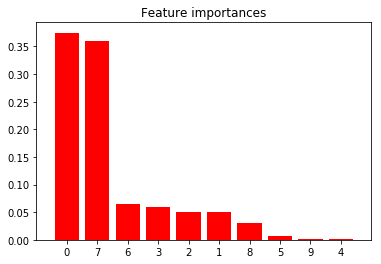

In [45]:
# Plot the feature importances of the forest
plt.figure(0)
plt.title("Feature importances")
plt.bar(range(Train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(Train.shape[1]), indices)
plt.xlim([-1, Train.shape[1]])
plt.show()

## iii- Decision Tree Model

In [46]:
from sklearn.tree import DecisionTreeClassifier

**We will remove all those having value < .05**

In [47]:
df_test_removed=df_test.drop(['Year', 'Quarter', 'Month', 'ID','Week'], axis=1)

In [48]:
test=datetounix(df_test_removed)

In [49]:
test.shape

(11808, 5)

In [50]:
# Same treatment with train data
df_train_removed=Train.drop(['Year', 'Quarter', 'Month', 'ID','Week'], axis=1)

In [51]:
train=df_train_removed

In [52]:
train.shape

(48120, 5)

In [53]:
# Create decision tree object
clf = DecisionTreeClassifier(criterion='gini', random_state = 13)

# fit the model
clf.fit(train, TARGET)

# predict the outcome for testing data
predictions = clf.predict(test)

# 5) Submission of results

In [54]:
submission = pd.DataFrame()
submission['ID'] = df_test.ID
submission['Vehicles'] = predictions

In [56]:
submission.head(10)

,ID,Vehicles
0,20170701001,70
1,20170701011,62
2,20170701021,46
3,20170701031,39
4,20170701041,40
5,20170701051,40
6,20170701061,40
7,20170701071,30
8,20170701081,47
9,20170701091,44
